In [1]:
import sys
from importlib import reload
sys.path.insert(0, r'../../../quetzal')

from quetzal.io import  gtfs_importer
from quetzal.model import stepmodel

In [2]:
reload(stepmodel)

<module 'quetzal.model.stepmodel' from '../../../quetzal\\quetzal\\model\\stepmodel.py'>

In [3]:
training_folder = '../../'

In [4]:
sm = stepmodel.read_zip(training_folder + r'model/transport/distribution.zip')

read_hdf: : 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.15it/s]


In [6]:
sm.road_links['capacity'] = 1000
sm.volumes['volume_car'] = sm.volumes['volume_car_owner']
constrained = sm.copy()
free = sm.copy()

In [7]:
constrained.step_road_pathfinder(maxiters=15, log=True, speedup=True, tolerance=0.01)

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 16.66it/s]


step: 0  moved = 100.0 %
relgap = 0.0 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 13.81it/s]


step: 1  moved = 37.9 %
relgap = 307.7 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:07<00:00, 16.56it/s]


step: 2  moved = 28.3 %
relgap = 48.0 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:07<00:00, 14.42it/s]


step: 3  moved = 21.7 %
relgap = 14.1 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:08<00:00, 13.93it/s]


step: 4  moved = 19.3 %
relgap = 6.3 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:08<00:00, 12.94it/s]


step: 5  moved = 18.0 %
relgap = 4.3 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:08<00:00, 14.51it/s]


step: 6  moved = 10.8 %
relgap = 3.5 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:09<00:00, 10.69it/s]


step: 7  moved = 16.6 %
relgap = 2.5 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:08<00:00, 15.79it/s]


step: 8  moved = 9.2 %
relgap = 2.2 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:08<00:00,  9.37it/s]


step: 9  moved = 8.8 %
relgap = 1.7 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:09<00:00,  8.67it/s]


step: 10  moved = 13.0 %
relgap = 1.4 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:08<00:00, 16.09it/s]


step: 11  moved = 9.1 %
relgap = 1.7 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:08<00:00, 15.66it/s]


step: 12  moved = 8.6 %
relgap = 1.2 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:09<00:00,  6.47it/s]


step: 13  moved = 6.3 %
relgap = 1.2 %


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:09<00:00, 12.11it/s]


step: 14  moved = 7.2 %
relgap = 1.0 %


In [8]:
free.step_road_pathfinder(maxiters=1, log=True, speedup=False, tolerance=0.001)

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:08<00:00, 12.82it/s]


step: 0  moved = 100.0 %
relgap = 0.0 %


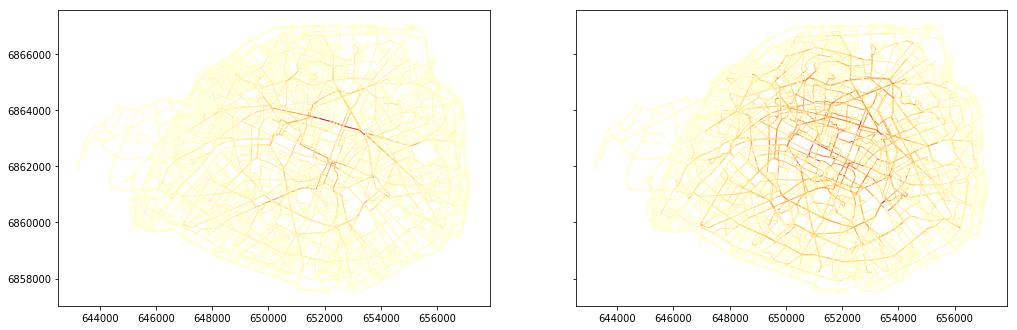

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[17, 7])

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

free.plot('road_links', column='flow',figsize=[10, 10], cmap='YlOrRd', linewidth=1, ax=axes[0])
constrained.plot('road_links', column='flow',figsize=[10, 10], cmap='YlOrRd', linewidth=1, ax=axes[1])

In [24]:
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm
from syspy.syspy_utils import data_visualization as dv
from syspy.syspy_utils import syscolors
spectral = list(reversed(['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']))

from shapely import geometry
def bandwidth(df, value, power=1, scale=1, legend_values=None, cmap=spectral, n_category=10, *args, **kwargs):

    if legend_values is None:
        s = df[value].copy()
        r = int(np.log10(s.mean())) 
        legend_values = [np.round(s.quantile(i/5), -r) for i in range(6)]
    
    df = df[[value, 'geometry']].copy().fillna(0)
    df = df.loc[df[value] > 0]
    mls = geometry.MultiPoint(list(df['geometry'].apply(lambda g: g.centroid)))

    b = mls.bounds
    delta = b[2] - b[0]
    rank = 0
    dx = delta /3 / len(legend_values)
    data = []
    for v in reversed(legend_values):
        g = geometry.LineString([
            ( b[2] - rank * dx, (b[1] + b[1]) / 2),
            ( b[2] - (rank + 1)*dx, (b[1] + b[1]) / 2)]
        )
        rank += 1
        data.append([v, g, str(v)])
        to_concat = pd.DataFrame(data, columns=[value, 'geometry', 'label'])
    df = pd.concat([df, to_concat])
    
    df = df.loc[df[value] > 0]
    plot = gpd.GeoDataFrame(df).plot(linewidth=0.1, color='grey', *args, **kwargs)
    
    power_series = (np.power(df[value], power))
    max_value = power_series.max()
    

    ratio = n_category / power_series.max()
    df['cat'] = np.round(power_series * ratio).fillna(0) - 1
    df = df.loc[df['cat']> 0]

    plot.set_yticks([])
    plot.set_xticks([])
    
    color_dict = dv.color_series(pd.Series(range(n_category)), cmap).to_dict()
    for cat in tqdm(set(df['cat'])):
        pool = df.loc[df['cat'] == cat]
        plot = gpd.GeoDataFrame(pool).plot(linewidth=cat*scale, ax=plot, color=color_dict[int(cat)]) 
       

    to_concat.apply(
        lambda x: plot.annotate(
            s=x[value], xy=x.geometry.centroid.coords[0], ha='center', va='bottom'
        ),axis=1
    )
    return plot

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.26it/s]


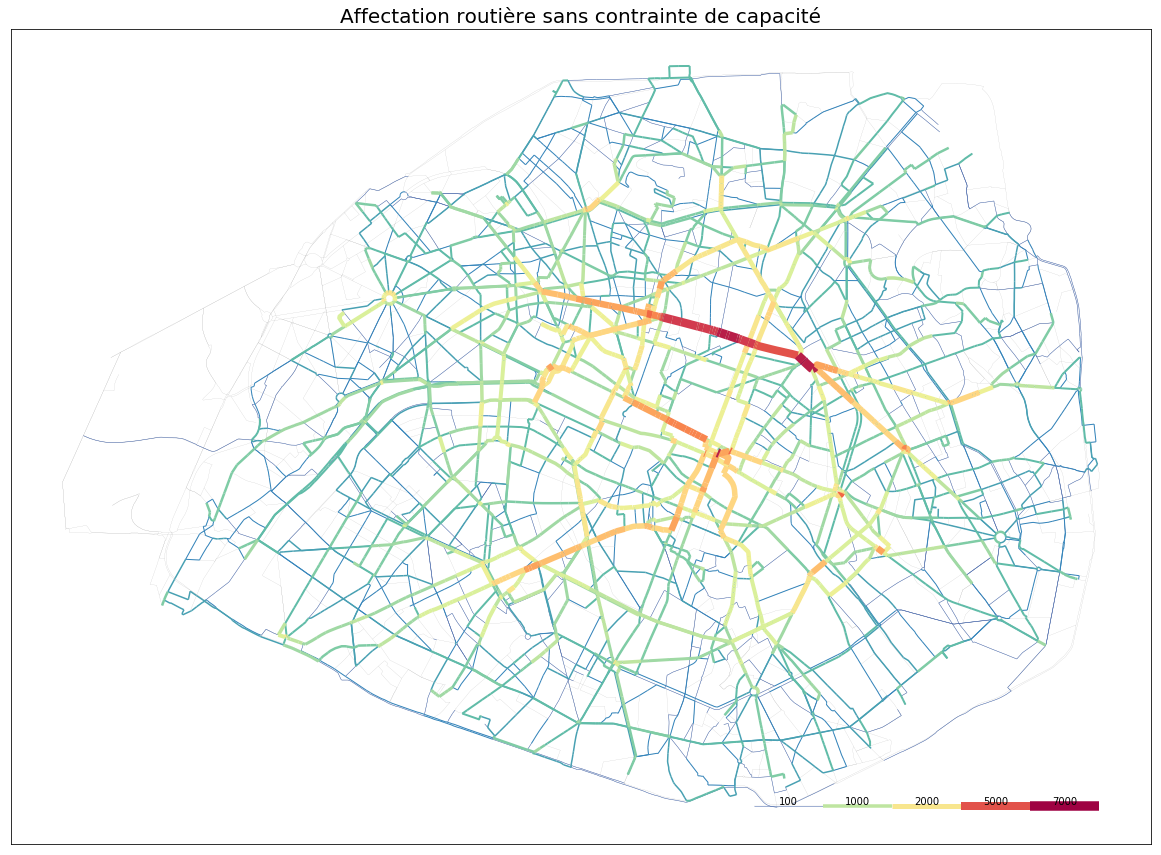

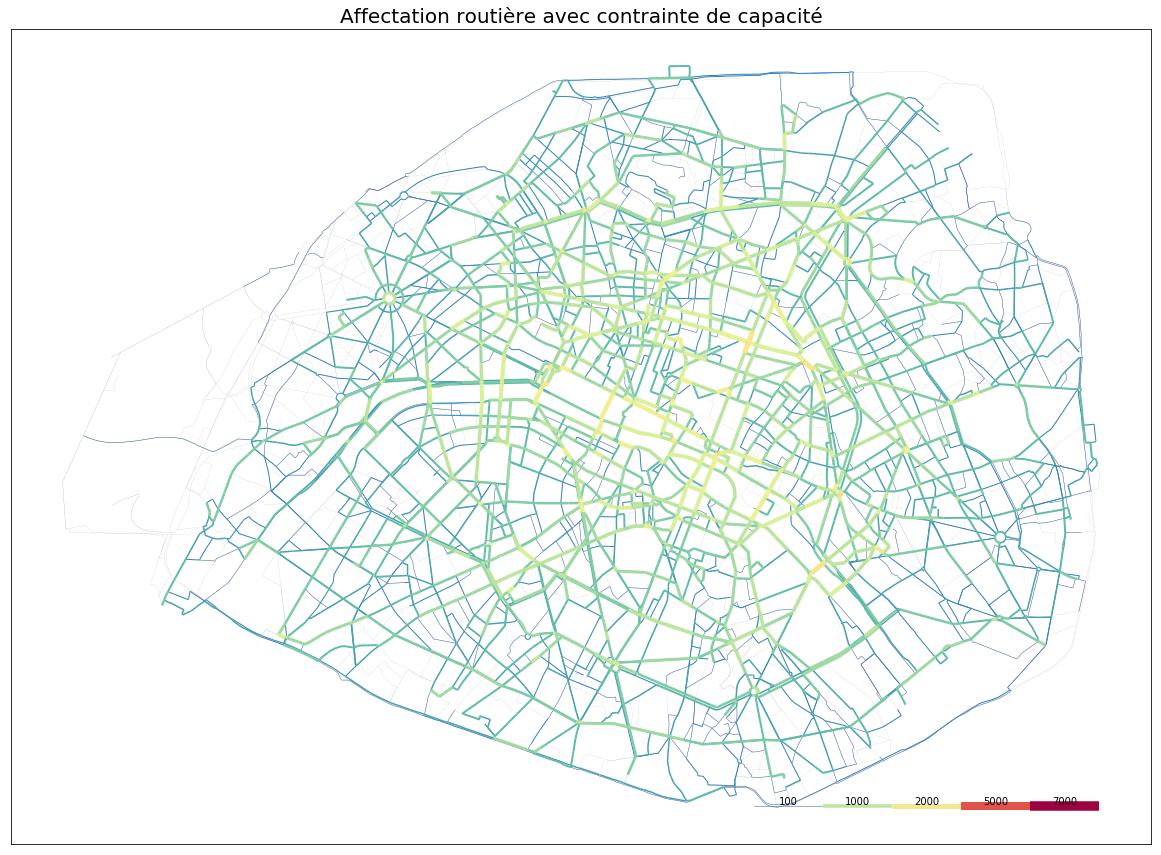

In [37]:
plot = bandwidth(free.road_links, 'flow',figsize=[25, 15], n_category=20, 
          power=0.5, scale=0.5, legend_values=[  100, 1000, 2000, 5000, 7000])
plot.set_title("Affectation routière sans contrainte de capacité", fontsize=20)
fig = plot.get_figure()
fig.savefig('road_pathfinder_a.png')

plot = bandwidth(constrained.road_links, 'flow',figsize=[25, 15], n_category=20, 
          power=0.5, scale=0.5, legend_values=[ 100, 1000, 2000, 5000, 7000])
plot.set_title("Affectation routière avec contrainte de capacité", fontsize=20)
fig = plot.get_figure()
fig.savefig('road_pathfinder_b.png')

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.24it/s]


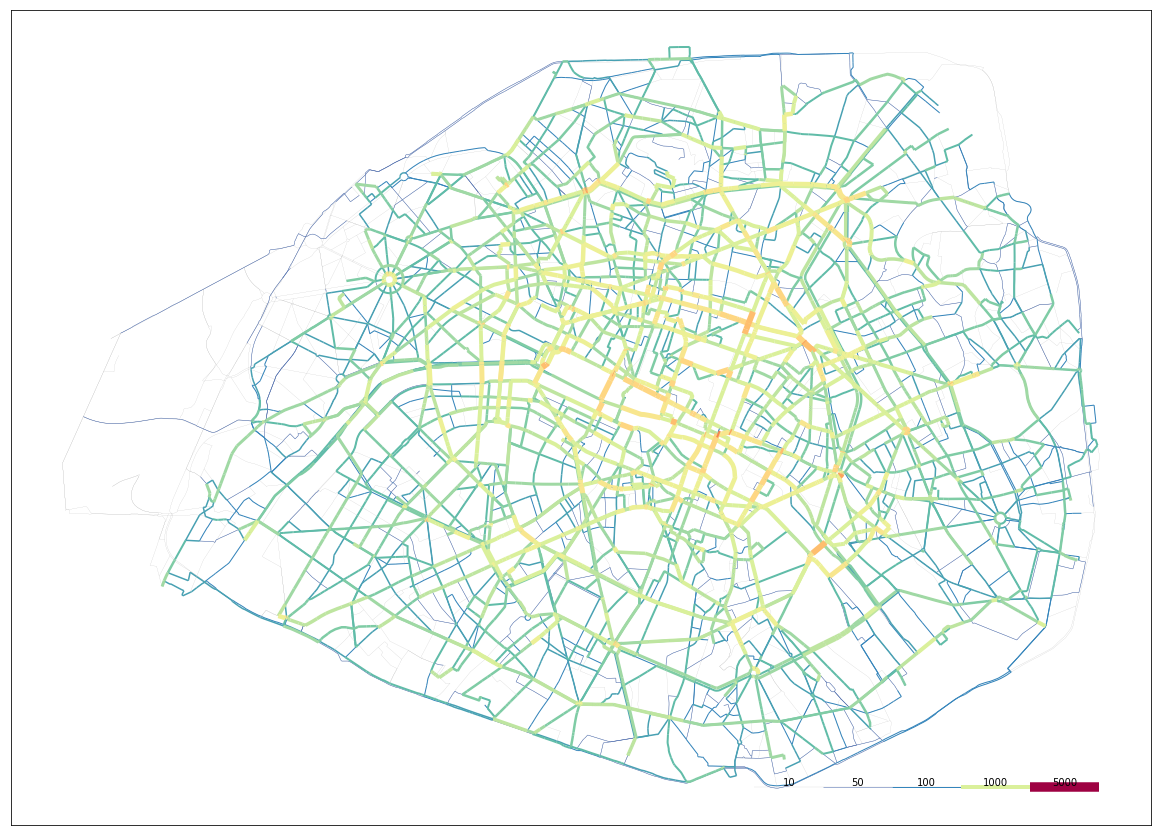

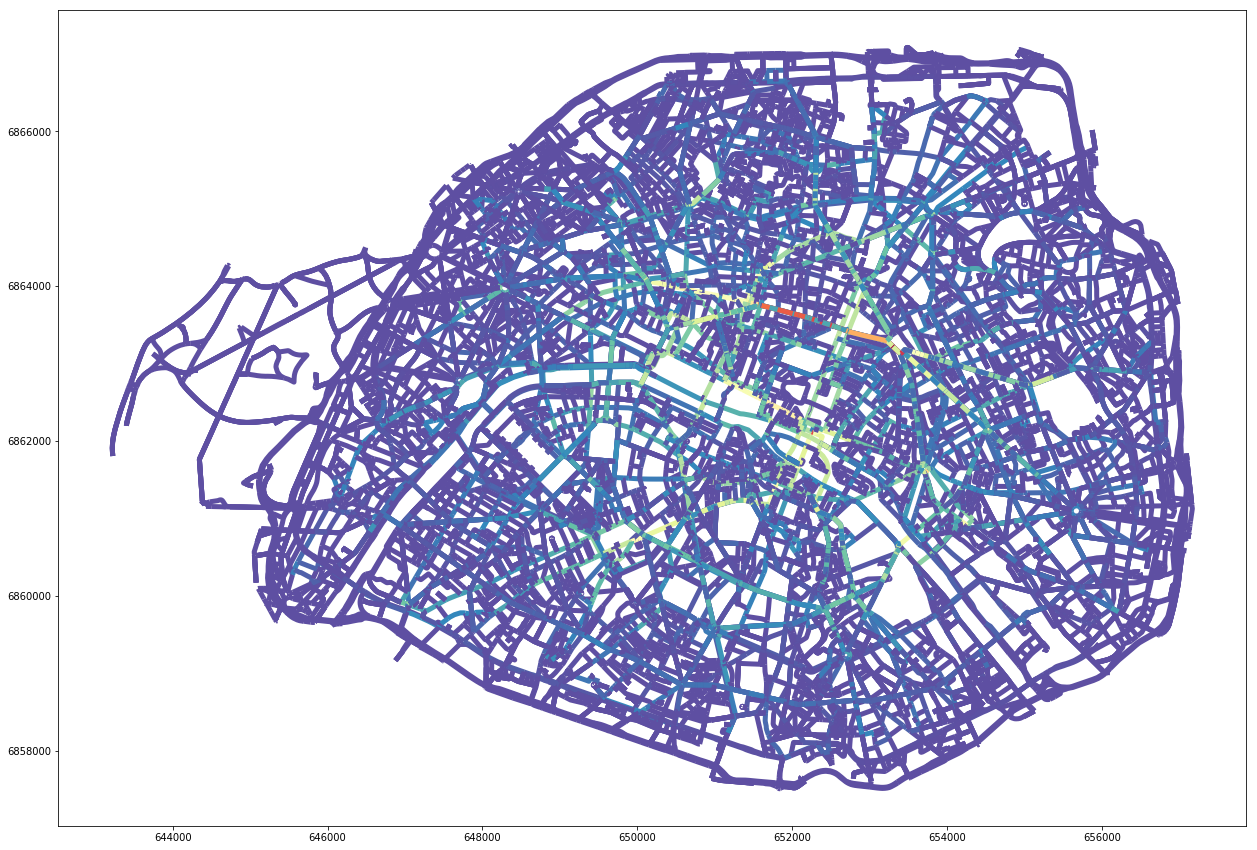

In [18]:
plot = free.plot('road_links', column='flow',figsize=[25, 15], cmap='Spectral_r', linewidth=5)

In [66]:
a = constrained.road_links
a['free_flow'] = free.road_links['flow']

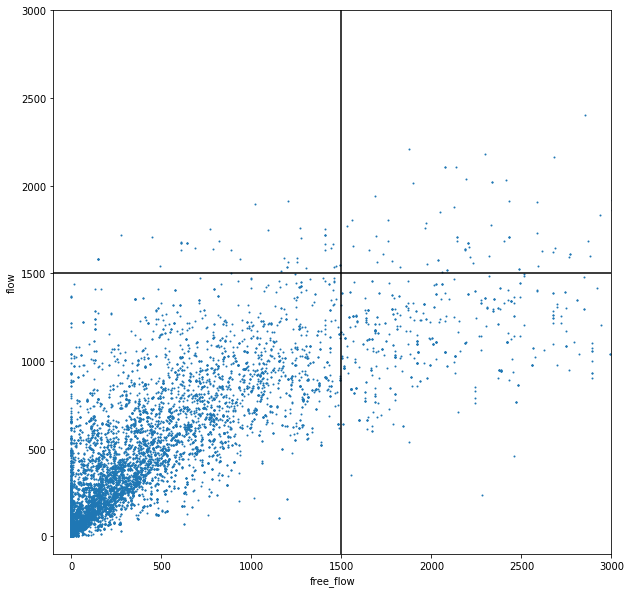

In [67]:
ax = a.plot(kind='scatter', y='flow', x='free_flow', figsize=[10, 10], s=1)
ax.set_xlim([-100, 3000])
ax.set_ylim([-100, 3000])
ax.hlines(1500, -100, 3000)
ax.vlines(1500, -100, 3000)

In [69]:
c = constrained.car_los.groupby(['origin', 'destination'])['actual_time'].min()

In [70]:
f = free.car_los.groupby(['origin', 'destination'])['actual_time'].min()

In [71]:
import pandas as pd
df = pd.DataFrame([c, f], index=['constrained', 'free']).T

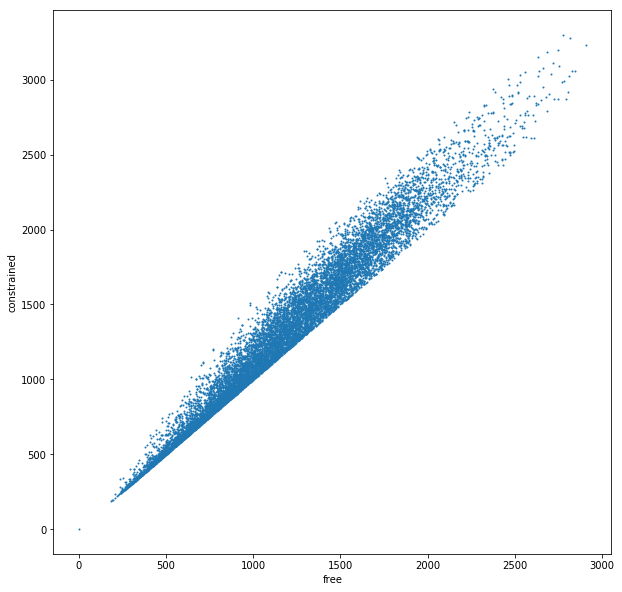

In [72]:
df.plot(kind='scatter', y='constrained', x='free', figsize=[10, 10], s=1)

# display

Il peut être utile de visualiser un chemin. C'est faisable grâce au module display

In [ ]:
projected = sm.change_epsg(4326, 'degree')

In [ ]:
from quetzal.io import display
reload(display)

In [ ]:
from imp import reload
reload(display)
display.all_car_paths(projected, 'zone_41',  'zone_73', we)

In [ ]:
sm.to_hdf(training_folder + 'model/bestpathfinder.hdf')

In [ ]:
sm.to_json(training_folder + 'model/bestpathfinder')

**Les développements en cours / à prévoir : **

- Le multichemin : existe déjà, on en parle à la fin de la session
- Mettre autre chose que du temps (par exemple tenir compte du prix) dans le coût généralisé : faisable et à faire

In [ ]:
car_speed = 10
sm.road_links['length'] = sm.road_links['geometry'].apply(lambda g: g.length)
sm.road_links['time'] = sm.road_links['length'] / car_speed